In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TransducedLM vs FusedTransducedLM Benchmark (BPE)

Compares two approaches to computing next-byte log-probabilities through
a BPE FST (maps GPT-2 token IDs → bytes):

- **TransducedLM**: two-phase (PeekabooState BFS decomposition, then LM-weighted search)
- **FusedTransducedLM**: single-pass (interleaved decomposition + LM search, no separate BFS)

Uses a 3-gram CharNgramLM over token IDs as the inner LM, with per-call
timeouts and a process-wide memory limit.

The BPE FST has a star topology: each token maps to its byte spelling via
a chain of epsilon-input arcs, then a single token-consuming arc back to
the start state. This creates a very different decomposition structure
from the PTB tokenizer (which has complex rewrite rules and 296 states).

In [21]:
import time, gc
import numpy as np
from transformers import AutoTokenizer
from transduction.applications.bpe import bpe_wfst
from transduction.fst import FST
from transduction.fsa import EPSILON
from transduction.lm.statelm import decode_hf_tokenizer
from transduction.util import Timeout, timelimit, set_memory_limit
set_memory_limit(8)

In [22]:
# ---- Tunable parameters ----
VOCAB_SIZE = None    # None → only tokens from training data (~43)
                     # int  → use that many from GPT-2 vocab (max ~50k)

In [23]:
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=False)
_, _, _decode, _ = decode_hf_tokenizer(tokenizer)
drop = {x.encode() for x in tokenizer.all_special_tokens}

# All non-special token IDs available
all_token_ids = sorted(i for i in range(len(_decode)) if _decode[i] not in drop)

# Training data for the inner n-gram LM
train_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "A stitch in time saves nine.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Actions speak louder than words.",
    "Practice makes perfect.",
    "Where there is a will, there is a way.",
] * 3

train_ids = [tokenizer.encode(s) for s in train_sentences]
train_used = sorted(set(tid for seq in train_ids for tid in seq))

# Select vocabulary subset
if VOCAB_SIZE is None:
    used_ids = train_used
else:
    used_ids = all_token_ids[:VOCAB_SIZE]
    # Always include training tokens so n-gram LM has valid data
    used_ids = sorted(set(used_ids) | set(train_used))

print(f'Training tokens: {len(train_used)}, Selected vocab: {len(used_ids)} / {len(all_token_ids)} total')

# Build subsampled BPE FST
def subsampled_bpe_fst(decode, token_ids, drop=frozenset()):
    """Build a BPE FST from a subset of token IDs."""
    m = FST()
    m.add_start(())
    for i in token_ids:
        x = decode[i]
        if x in drop:
            continue
        bx = tuple(x)
        for j in range(len(bx)):
            m.add_arc(bx[:j], EPSILON, bytes([bx[j]]), bx[:j+1])
        m.add_arc(bx, i, EPSILON, ())
    m.add_stop(())
    return m

t0 = time.perf_counter()
bpe_fst = subsampled_bpe_fst(_decode, used_ids, drop)
print(f'BPE FST built in {time.perf_counter()-t0:.3f}s: '
      f'{len(bpe_fst.states)} states, |A|={len(bpe_fst.A)}, |B|={len(bpe_fst.B)}')

Training tokens: 43, Selected vocab: 43 / 50256 total
BPE FST built in 0.000s: 140 states, |A|=44, |B|=34


In [24]:
# Generate target byte sequence by transducing token IDs through the FST
text = "The quick brown fox jumps over the lazy dog."
token_ids_test = tokenizer.encode(text)
target_seq = list(bpe_fst.transduce(token_ids_test))
print(f'Text: {text!r}')
print(f'Token IDs: {token_ids_test}')
print(f'Target (bytes): {len(target_seq)} symbols')
print(f'Decoded: {b"".join(target_seq).decode()!r}')

# Train inner LM on token-ID sequences
from transduction.lm.ngram import CharNgramLM
source_alpha = bpe_fst.A - {EPSILON}
inner_lm = CharNgramLM.train(train_ids, n=3, alpha=0.5, alphabet=source_alpha)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Text: 'The quick brown fox jumps over the lazy dog.'
Token IDs: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290, 13]
Target (bytes): 44 symbols
Decoded: 'The quick brown fox jumps over the lazy dog.'
Inner LM: alphabet=44 symbols


## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs. Both use
`K=20`, `max_expansions=200`, with a 3s timeout per step.

In [16]:
from collections import defaultdict
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM

MAX_DECODE = 100             # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 10                # max items carried forward
LM_TIMEOUT = 30               # seconds per step

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

for name, cls in [
    ('TransducedLM', TransducedLM),
    ('FusedTransducedLM', FusedTransducedLM),
]:
    print(f'\n{name} (K={MAX_BEAM}, max_expansions={MAX_SEARCH}):')
    if cls is TransducedLM:
        tlm = cls(inner_lm, bpe_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH)
    else:
        tlm = cls(inner_lm, bpe_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)
    try:
        with timelimit(LM_TIMEOUT):
            state = tlm.initial()
    except (Timeout, MemoryError) as e:
        print(f'  initial() failed: {type(e).__name__}: {e}')
        continue
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        try:
            with timelimit(LM_TIMEOUT):
                t0 = time.perf_counter()
                lp = state.logp_next[y]
                state = state >> y
                t1 = time.perf_counter()
        except Timeout:
            print(f'  step {i+1} TIMEOUT ({LM_TIMEOUT}s)')
            break
        except MemoryError:
            print(f'  step {i+1} OOM')
            break
        elapsed = t1 - t0
        lm_results[name].append((i + 1, elapsed, lp))
        print(f'  {i+1:2d}: {elapsed*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()


TransducedLM (K=10, max_expansions=200):
   1:    173.7 ms  logp=-4.4900
   2:    162.1 ms  logp=-0.6925
   3:    157.1 ms  logp=-0.1305
   4:    144.1 ms  logp=-1.0085
   5:    125.6 ms  logp=-0.8267
   6:    125.7 ms  logp=0.0000
   7:    115.0 ms  logp=0.0000
   8:    120.7 ms  logp=0.0000
   9:    109.4 ms  logp=0.0000
  10:    146.9 ms  logp=-1.0077
  11:    124.3 ms  logp=-0.6931
  12:    133.1 ms  logp=-0.1335
  13:    118.6 ms  logp=0.0000
  14:    119.4 ms  logp=0.0000
  15:    127.9 ms  logp=0.0000
  16:    163.8 ms  logp=-1.0077
  17:    110.8 ms  logp=-0.8267
  18:    108.7 ms  logp=0.0000
  19:    116.8 ms  logp=0.0000
  20:    177.6 ms  logp=-1.0077
  21:    121.3 ms  logp=-0.8267
  22:    122.1 ms  logp=0.0000
  23:    130.3 ms  logp=0.0000
  24:    120.6 ms  logp=0.0000
  25:    124.0 ms  logp=0.0000
  26:    188.7 ms  logp=-1.0077
  27:    130.3 ms  logp=-0.8267
  28:    132.7 ms  logp=0.0000
  29:    125.9 ms  logp=0.0000
  30:    133.9 ms  logp=0.0000
  31:    205.1

In [17]:
# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (ms)":>14s} {"Steps":>6s}')
print('-' * 57)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data) * 1000
    print(f'{name:<25s} {total:10.2f} {avg:14.1f} {len(data):6d}')
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    t0 = sum(t for _, t, _ in d0)
    t1 = sum(t for _, t, _ in d1)
    if t1 > 0:
        print(f'\nFused speedup (overall): {t0/t1:.2f}x')
    # Exclude step 1 (amortization penalty for Fused)
    if len(d0) > 1 and len(d1) > 1:
        t0_skip1 = sum(t for _, t, _ in d0[1:])
        t1_skip1 = sum(t for _, t, _ in d1[1:])
        if t1_skip1 > 0:
            print(f'Fused speedup (step 2+): {t0_skip1/t1_skip1:.2f}x')


Algorithm                  Total (s)  Avg/step (ms)  Steps
---------------------------------------------------------
FusedTransducedLM               1.41           32.1     44
TransducedLM                    6.28          142.6     44

Fused speedup (overall): 0.22x
Fused speedup (step 2+): 0.22x


Max |logp| diff: 0.000000


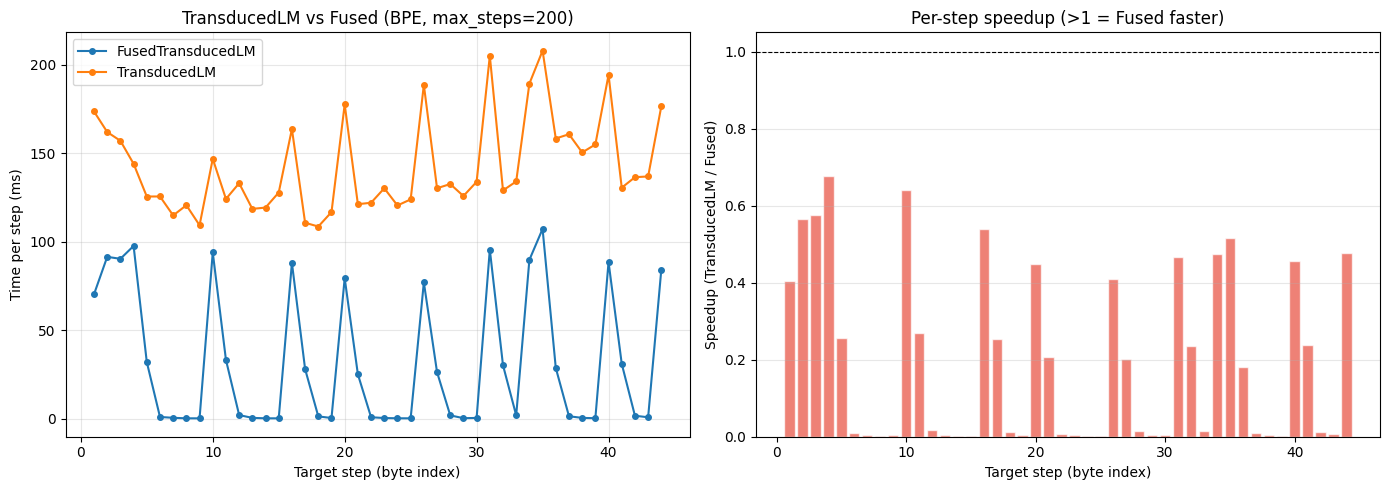

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: time per step
ax = axes[0]
for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] * 1000 for d in data]  # ms
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step (byte index)')
ax.set_ylabel('Time per step (ms)')
ax.set_title(f'TransducedLM vs Fused (BPE, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: per-step speedup
ax = axes[1]
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    n = min(len(d0), len(d1))
    steps = [d0[i][0] for i in range(n)]
    speedups = [d0[i][1] / d1[i][1] if d1[i][1] > 0 else 0 for i in range(n)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    ax.bar(steps, speedups, color=colors, alpha=0.7, edgecolor='white')
    ax.axhline(1.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Target step (byte index)')
    ax.set_ylabel('Speedup (TransducedLM / Fused)')
    ax.set_title('Per-step speedup (>1 = Fused faster)')
    ax.grid(True, alpha=0.3, axis='y')

    logp_diffs = [abs(d0[i][2] - d1[i][2]) for i in range(n)]
    print(f'Max |logp| diff: {max(logp_diffs):.6f}')

plt.tight_layout()
plt.show()

## FST Structure

The BPE FST has a star topology: from the start state `()`, each token
creates a chain of epsilon-input arcs that emit the token's bytes one at
a time, then a single arc consuming the token ID returns to `()`.

Below we show the FST statistics and a few example token chains.

In [19]:
# Show some example token chains
sample_ids = token_ids_test[:8]
for tid in sample_ids:
    token_bytes = _decode[tid]
    display_str = token_bytes.decode('utf-8', errors='replace')
    print(f'  token {tid:5d} = {display_str!r:12s}  ({len(token_bytes)} bytes: {list(token_bytes)})')

# Arc counts by type
eps_in = sum(1 for s in bpe_fst.states for a, b, t in bpe_fst.arcs(s) if a == EPSILON)
eps_out = sum(1 for s in bpe_fst.states for a, b, t in bpe_fst.arcs(s) if b == EPSILON)
print(f'\nFST: {len(bpe_fst.states)} states, eps-input arcs: {eps_in}, eps-output arcs: {eps_out}')

  token   464 = 'The'         (3 bytes: [84, 104, 101])
  token  2068 = ' quick'      (6 bytes: [32, 113, 117, 105, 99, 107])
  token  7586 = ' brown'      (6 bytes: [32, 98, 114, 111, 119, 110])
  token 21831 = ' fox'        (4 bytes: [32, 102, 111, 120])
  token 18045 = ' jumps'      (6 bytes: [32, 106, 117, 109, 112, 115])
  token   625 = ' over'       (5 bytes: [32, 111, 118, 101, 114])
  token   262 = ' the'        (4 bytes: [32, 116, 104, 101])
  token 16931 = ' lazy'       (5 bytes: [32, 108, 97, 122, 121])

FST: 1313 states, eps-input arcs: 1312, eps-output arcs: 1023


In [20]:
# Most likely next bytes from the final state
logp = state.logp_next
syms = sorted(logp.keys(), key=lambda s: logp[s], reverse=True)[:15]
print(f'{"symbol":>8s}  {"char":>6s}  {"logp":>8s}  {"prob":>8s}')
print("-" * 36)
for s in syms:
    if isinstance(s, (bytes, bytearray)):
        val = s[0]
        ch = chr(val) if 32 <= val <= 126 else f'\\x{val:02x}'
    elif isinstance(s, int):
        ch = chr(s) if 32 <= s <= 126 else f'\\x{s:02x}'
    else:
        ch = repr(s)
    print(f'{str(s):>8s}  {ch:>6s}  {logp[s]:8.4f}  {np.exp(logp[s]):8.4f}')

  symbol    char      logp      prob
------------------------------------
    b' '           -1.3805    0.2515
    b'.'       .   -1.5959    0.2027
    b'"'       "   -2.2958    0.1007
    b'i'       i   -2.9899    0.0503
    b'a'       a   -3.0455    0.0476
    b'o'       o   -3.2686    0.0381
    b'e'       e   -3.8600    0.0211
    b'u'       u   -4.0359    0.0177
    b'r'       r   -4.1585    0.0156
    b'c'       c   -4.4608    0.0116
    b't'       t   -4.9914    0.0068
    b'p'       p   -4.9914    0.0068
    b'l'       l   -5.0968    0.0061
    b's'       s   -5.2145    0.0054
    b'v'       v   -5.2145    0.0054
